# Генетические алгоритмы
### Вариант №17

## Лабораторная работа №1: Простой генетический алгоритм

$$ f(x) = \frac{\cos(\exp{(x)})}{\sin({\log{(x)}})}, x \in [2,4] $$

$$min \texttt{ }f(x) = \frac{\cos(\exp{(x)})}{\sin({\log{(x)}})} \approx -1.38476 $$


 Gen |   Best_x |       Best_f |       Mean_f |  Time(s)
--------------------------------------------------------
   0 |    2.745 |    -1.168921 |    -0.409121 |   0.0004
   1 |    2.248 |    -1.379278 |    -0.548675 |   0.0003
   2 |    2.245 |    -1.382203 |    -0.759144 |   0.0003
   3 |    2.240 |    -1.384639 |    -1.211791 |   0.0003
   4 |    2.238 |    -1.384764 |    -1.373112 |   0.0003
   5 |    2.238 |    -1.384764 |    -1.361731 |   0.0003
   6 |    2.238 |    -1.384764 |    -1.377298 |   0.0004
   7 |    2.238 |    -1.384764 |    -1.369395 |   0.0003
   8 |    2.238 |    -1.384764 |    -1.373058 |   0.0005
   9 |    2.238 |    -1.384764 |    -1.379324 |   0.0004
  10 |    2.238 |    -1.384764 |    -1.351899 |   0.0003
  11 |    2.238 |    -1.384764 |    -1.383980 |   0.0003
  12 |    2.238 |    -1.384764 |    -1.383903 |   0.0003
  13 |    2.238 |    -1.384764 |    -1.381956 |   0.0003
  14 |    2.238 |    -1.384764 |    -1.381509 |   0.0003

 скан: x≈2.238500, f≈-1.38477

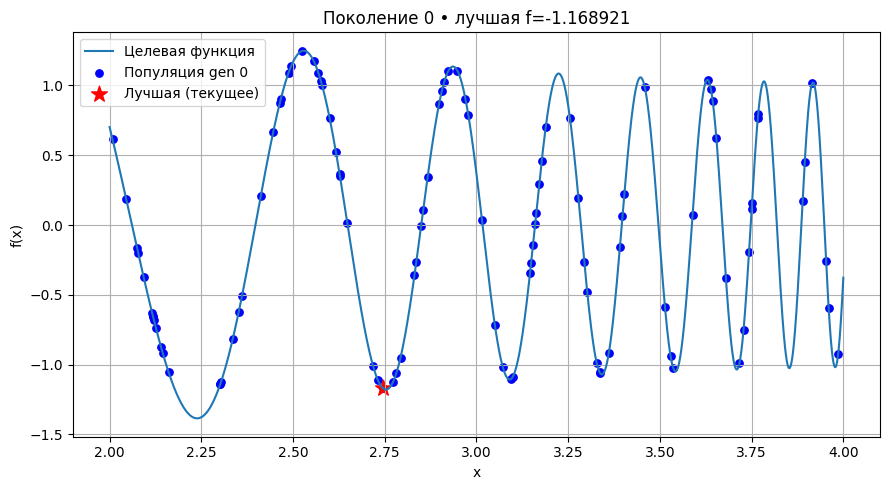

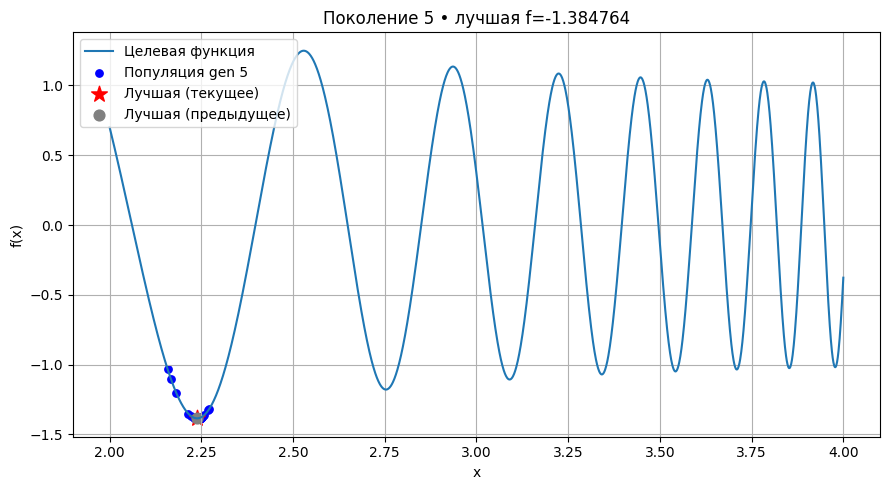

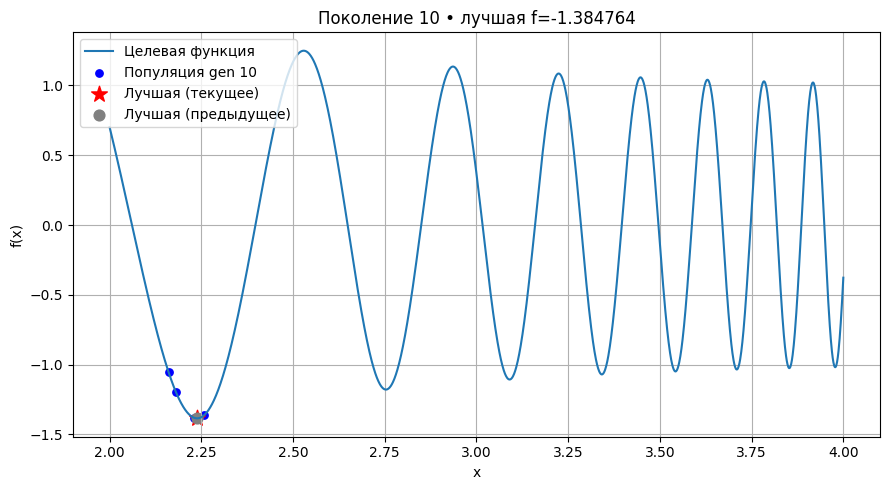

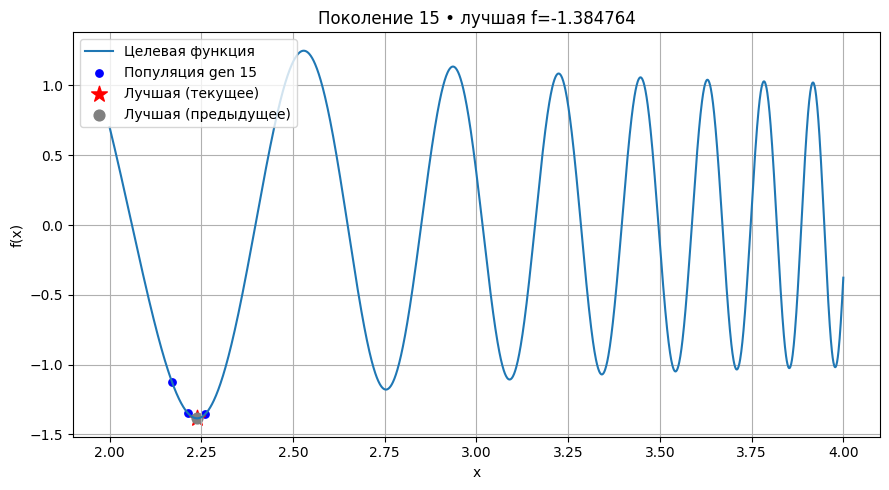

In [1]:
import math
import random
import time
from dataclasses import dataclass
from typing import Callable, List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt


def f(x: float) -> float:
    try:
        return math.cos(math.exp(x)) / math.sin(math.log(x))
    except Exception:
        return float("inf")

@dataclass
class GAConfig:
    x_min: float = 2.0
    x_max: float = 4.0
    precision: int = 3

    pop_size: int = 50
    generations: int = 60

    crossover_rate: float = 0.85
    mutation_rate: float = 0.12          
    elitism: int = 4
    tournament_size: int = 4

    sigma_init: float = 0.08
    sigma_floor: float = 0.001
    sigma_decay: float = 0.96

    cx_alpha: float = 0.10

    seed: int = 7

    avoid_min_at_start: bool = True
    avoid_window_dx: float = 0.06  

def clamp(x, a, b): return max(a, min(b, x))
def roundp(x, p): return round(x, p)

def arithmetic_crossover(p1: float, p2: float, alpha: float) -> Tuple[float, float]:
    lo, hi = (p1, p2) if p1 <= p2 else (p2, p1)
    L = hi - lo
    a = lo - alpha * L
    b = hi + alpha * L
    r = random.random()
    c1 = a + r * (b - a)
    c2 = a + (1 - r) * (b - a)
    return c1, c2

def mutate(x: float, rate: float, sigma: float, cfg: GAConfig) -> float:
    if random.random() < rate:
        x = x + random.gauss(0.0, sigma)
        x = clamp(x, cfg.x_min, cfg.x_max)
        x = roundp(x, cfg.precision)
    return x

def evaluate(pop: List[float], func: Callable[[float], float]) -> List[float]:
    return [func(x) for x in pop]

def tournament_select(pop: List[float], fitness: List[float], k: int) -> float:
    idxs = random.sample(range(len(pop)), k)
    best_idx = min(idxs, key=lambda i: fitness[i])   
    return pop[best_idx]

def dense_scan_min(x_min=2.0, x_max=4.0) -> Tuple[float, float]:
    xs = np.linspace(x_min, x_max, 40001)
    ys = np.cos(np.exp(xs)) / np.sin(np.log(xs))
    i = int(np.argmin(ys))
    return float(xs[i]), float(ys[i])

def init_population(cfg: GAConfig, forbid: Tuple[float, float] | None) -> List[float]:
    pop = []
    while len(pop) < cfg.pop_size:
        x = roundp(random.uniform(cfg.x_min, cfg.x_max), cfg.precision)
        if forbid and (forbid[0] <= x <= forbid[1]):
            continue
        pop.append(x)
    return pop

def run_ga(func: Callable[[float], float], cfg: GAConfig) -> Dict:
    random.seed(cfg.seed)

    approx_x, approx_y = dense_scan_min(cfg.x_min, cfg.x_max)
    forbid = None
    if cfg.avoid_min_at_start:
        a = clamp(approx_x - cfg.avoid_window_dx, cfg.x_min, cfg.x_max)
        b = clamp(approx_x + cfg.avoid_window_dx, cfg.x_min, cfg.x_max)
        forbid = (a, b)

    pop = init_population(cfg, forbid)
    fitness = evaluate(pop, func)

    pop_history: List[List[float]] = [pop.copy()]     
    best_history: List[Tuple[float, float]] = []      
    table_rows: List[Dict] = []

    for gen in range(cfg.generations):
        gen_start_time = time.time()
        
        i_best = int(np.argmin(fitness))
        best_x_gen = pop[i_best]
        best_f_gen = float(fitness[i_best])

        best_history.append((best_x_gen, best_f_gen))

        elite_idx = np.argsort(fitness)[:cfg.elitism]
        next_pop = [pop[i] for i in elite_idx]

        sigma = max(cfg.sigma_floor, cfg.sigma_init * (cfg.sigma_decay ** gen))

        while len(next_pop) < cfg.pop_size:
            p1 = tournament_select(pop, fitness, cfg.tournament_size)
            p2 = tournament_select(pop, fitness, cfg.tournament_size)

            if random.random() < cfg.crossover_rate:
                c1, c2 = arithmetic_crossover(p1, p2, cfg.cx_alpha)
            else:
                c1, c2 = p1, p2

            c1 = mutate(c1, cfg.mutation_rate, sigma, cfg)
            c2 = mutate(c2, cfg.mutation_rate, sigma, cfg)

            next_pop.extend([c1, c2])

        pop = [roundp(clamp(x, cfg.x_min, cfg.x_max), cfg.precision) for x in next_pop[:cfg.pop_size]]
        fitness = evaluate(pop, func)
        pop_history.append(pop.copy())
        
        # Измеряем время выполнения всего поколения
        gen_end_time = time.time()
        gen_time = gen_end_time - gen_start_time
        
        table_rows.append({
            "generation": gen,
            "best_x": best_x_gen,
            "best_f": best_f_gen,
            "mean_f": float(np.mean(fitness)),
            "time": gen_time,
        })

    final_best = best_history[-1]
    return {
        "pop_history": pop_history,
        "best_history": best_history,
        "final_best": final_best,
        "table": table_rows,
        "approx_min": (approx_x, approx_y),
        "cfg": cfg,
    }

def compute_curve(x_min: float, x_max: float):
    xs = np.linspace(x_min, x_max, 2000)
    ys = np.cos(np.exp(xs)) / np.sin(np.log(xs))
    return xs, ys

def plot_snapshot(xs, ys, gen_idx: int, pop_history: List[List[float]], best_history: List[Tuple[float, float]]):
    pop_cur = pop_history[gen_idx]
    best_cur_x, best_cur_f = best_history[gen_idx] if gen_idx < len(best_history) else best_history[-1]
    prev_best = best_history[gen_idx - 1] if gen_idx - 1 >= 0 else None

    plt.figure(figsize=(9, 5))
    plt.plot(xs, ys, label="Целевая функция")
    plt.scatter(pop_cur, [f(x) for x in pop_cur], s=28, label=f"Популяция gen {gen_idx}", color="blue")
    plt.scatter([best_cur_x], [best_cur_f], s=140, marker="*", color="red", label="Лучшая (текущее)")
    if prev_best is not None:
        plt.scatter([prev_best[0]], [prev_best[1]], s=60, color="gray", label="Лучшая (предыдущее)")
    plt.title(f"Поколение {gen_idx} • лучшая f={best_cur_f:.6f}")
    plt.xlabel("x"); plt.ylabel("f(x)")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

def print_table(rows: List[Dict]) -> None:
    header = f"{'Gen':>4} | {'Best_x':>8} | {'Best_f':>12} | {'Mean_f':>12} | {'Time(s)':>8}"
    print("\n" + header)
    print("-" * len(header))
    for r in rows:
        print(f"{r['generation']:>4} | {r['best_x']:>8.3f} | {r['best_f']:>12.6f} | {r['mean_f']:>12.6f} | {r['time']:>8.4f}")

def main():
    cfg = GAConfig(
        pop_size=100,
        generations=15,
        crossover_rate=0.85,
        mutation_rate=0.05,
        elitism=4,
        tournament_size=4,
        precision=3,
        sigma_init=0.08,
        sigma_floor=0.001,
        sigma_decay=0.96,
        cx_alpha=0.10,
        seed=7,
        avoid_min_at_start=True,
        avoid_window_dx=0.06,
    )

    res = run_ga(f, cfg)
    pop_history = res["pop_history"]
    best_history = res["best_history"]
    rows = res["table"]
    approx_x, approx_y = res["approx_min"]

    print_table(rows)
    print(f"\n скан: x≈{approx_x:.6f}, f≈{approx_y:.6f}")

    xs, ys = compute_curve(cfg.x_min, cfg.x_max)

    gens_to_show = [0, 5, 10, 20, 30, 40, 50, 60]
    gens_to_show = [g for g in gens_to_show if 0 <= g < len(pop_history)]
    if (len(pop_history)-1) not in gens_to_show:
        gens_to_show.append(len(pop_history)-1)

    for g in gens_to_show:
        plot_snapshot(xs, ys, g, pop_history, best_history)


if __name__ == "__main__":
    main()


# Лабораторная работа №2: Оптимизация многомерных функций с помощью генетических алгоритмов

$$
    f_{1a} = \sum_{i=1}^{n}{x_i}^2, \texttt{ }x \in [-5.12, 5.12]
$$

In [2]:
import os
import time
import random
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Optional

import numpy as np
import pandas as pd

SEED = 42
BOUND_LOW, BOUND_HIGH = -5.12, 5.12
MUTATION_SIGMA_FRACTION = 0.1

N_LIST = [10, 25, 50, 100]                
PC_LIST = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]   
PM_LIST = [0.001, 0.01, 0.05, 0.1, 0.2]    

MAX_GENERATIONS = 200 
STALL_BEST_REPEAT = 10
THRESHOLD = 5e-3

OUT_DIR = "tables"

def dejong_f1(x: np.ndarray) -> float:
    return float(np.sum(x ** 2))



def set_seed(seed: Optional[int] = None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)


def clip_to_bounds(x: np.ndarray, low: float, high: float) -> np.ndarray:
    return np.clip(x, low, high)


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

@dataclass
class GAState:
    pop: np.ndarray
    fit: np.ndarray
    best_f: float
    best_x: np.ndarray
    gen: int = 0


class SimpleGA:
    def __init__(
        self,
        n: int,
        bounds: Tuple[float, float],
        pop_size: int,
        p_cross: float,
        p_mut: float,
        tournament_k: int = 3,
        elitism: int = 2,
        objective: Callable[[np.ndarray], float] = dejong_f1,
        seed: Optional[int] = SEED,
    ):
        self.n = n
        self.low, self.high = bounds
        self.pop_size = pop_size
        self.p_cross = p_cross
        self.p_mut = p_mut
        self.tournament_k = tournament_k
        self.elitism = min(elitism, max(0, pop_size - 1))
        self.objective = objective
        self.mutation_sigma = (self.high - self.low) * MUTATION_SIGMA_FRACTION
        set_seed(seed)

    def _init_population(self) -> np.ndarray:
        return np.random.uniform(self.low, self.high, size=(self.pop_size, self.n))

    def _evaluate(self, pop: np.ndarray) -> np.ndarray:
        return np.array([self.objective(ind) for ind in pop], dtype=float)
    def _tournament(self, pop: np.ndarray, fitness: np.ndarray) -> np.ndarray:
        new = []
        idxs = np.arange(self.pop_size)
        for _ in range(self.pop_size):
            k_idx = np.random.choice(idxs, size=self.tournament_k, replace=False)
            winner = k_idx[np.argmin(fitness[k_idx])]
            new.append(pop[winner])
        return np.array(new)

    def _crossover_pair(self, a: np.ndarray, b: np.ndarray, alpha: float = 0.5) -> np.ndarray:
        c_min = np.minimum(a, b)
        c_max = np.maximum(a, b)
        I = c_max - c_min
        low = c_min - alpha * I
        high = c_max + alpha * I
        child = np.random.uniform(low, high)
        return clip_to_bounds(child, self.low, self.high)

    def _crossover(self, mating_pool: np.ndarray) -> np.ndarray:
        new = []
        idxs = np.random.permutation(self.pop_size)
        for i in range(0, self.pop_size, 2):
            p1 = mating_pool[idxs[i]]
            p2 = mating_pool[idxs[i + 1 if i + 1 < self.pop_size else 0]]
            if np.random.rand() < self.p_cross:
                c1 = self._crossover_pair(p1, p2)
                c2 = self._crossover_pair(p2, p1)
            else:
                c1, c2 = p1.copy(), p2.copy()
            new.extend([c1, c2])
        return np.array(new[: self.pop_size])

    def _mutate(self, pop: np.ndarray) -> np.ndarray:
        mask = np.random.rand(*pop.shape) < self.p_mut
        noise = np.random.normal(loc=0.0, scale=self.mutation_sigma, size=pop.shape)
        out = pop.copy()
        out[mask] += noise[mask]
        return clip_to_bounds(out, self.low, self.high)

    def _apply_elitism(self, old_pop, old_fit, new_pop, new_fit):
        if self.elitism <= 0:
            return new_pop, new_fit
        elite_idx = np.argsort(old_fit)[: self.elitism]
        worst_idx = np.argsort(new_fit)[-self.elitism:]
        new_pop[worst_idx] = old_pop[elite_idx]
        new_fit[worst_idx] = old_fit[elite_idx]
        return new_pop, new_fit

    def _step(self, state: GAState) -> GAState:
        mating_pool = self._tournament(state.pop, state.fit)
        children = self._crossover(mating_pool)
        children = self._mutate(children)
        children_fit = self._evaluate(children)
        children, children_fit = self._apply_elitism(state.pop, state.fit, children, children_fit)

        pop, fit = children, children_fit
        best_idx = int(np.argmin(fit))
        best_f = float(fit[best_idx])
        best_x = pop[best_idx].copy()
        return GAState(pop=pop, fit=fit, best_f=best_f, best_x=best_x, gen=state.gen + 1)

    def run_until(
        self,
        max_generations: int = MAX_GENERATIONS,
        stall_generations: int = STALL_BEST_REPEAT,
        threshold: Optional[float] = None,  
    ) -> Tuple[int, float, float, str]:

        t0 = time.time()
        pop = self._init_population()
        fit = self._evaluate(pop)
        best_f = float(np.min(fit))
        best_stall = 0

        state = GAState(pop=pop, fit=fit, best_f=best_f, best_x=pop[np.argmin(fit)].copy(), gen=0)
        stop_reason = ""
        if threshold is not None and state.best_f <= threshold:
            stop_reason = f"limit {threshold:g} on 0"
            elapsed_ms = (time.time() - t0) * 1000.0
            return (0, elapsed_ms, state.best_f, stop_reason)

        for _ in range(1, max_generations + 1):
            prev_best = state.best_f
            state = self._step(state)

            if state.best_f + 1e-15 < prev_best:
                best_stall = 0
            else:
                best_stall += 1

            if threshold is not None and state.best_f <= threshold:
                stop_reason = f"limit {threshold:g}"
                break

            if threshold is None and best_stall >= stall_generations:
                stop_reason = f"stz {stall_generations}"
                break

        if stop_reason == "":
            stop_reason = "limit"

        elapsed_ms = (time.time() - t0) * 1000.0
        return (state.gen, elapsed_ms, state.best_f, stop_reason)

def build_tables_for_N(
    n_dim: int,
    bounds: Tuple[float, float],
    pop_size: int,
    pc_list: List[float],
    pm_list: List[float],
    max_generations: int = MAX_GENERATIONS,
    stall_generations: int = STALL_BEST_REPEAT,
    threshold: float = THRESHOLD,
    seed: Optional[int] = SEED,
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    stall_rows = []
    thresh_rows = []

    for pc in pc_list:
        stall_row = []
        thresh_row = []
        for pm in pm_list:
            ga = SimpleGA(n=n_dim, bounds=bounds, pop_size=pop_size,
                          p_cross=pc, p_mut=pm, seed=seed)

            gens1, t1_ms, best1, reason1 = ga.run_until(
                max_generations=max_generations,
                stall_generations=stall_generations,
                threshold=None
            )
            stall_row.append(f"{t1_ms:.1f} ({gens1})")

            ga2 = SimpleGA(n=n_dim, bounds=bounds, pop_size=pop_size,
                           p_cross=pc, p_mut=pm, seed=seed)
            gens2, t2_ms, best2, reason2 = ga2.run_until(
                max_generations=max_generations,
                stall_generations=stall_generations,
                threshold=threshold
            )
            if "Достигнут порог" in reason2:
                thresh_row.append(f"{t2_ms:.1f} ({gens2})")
            else:
                thresh_row.append("—")

        stall_rows.append(stall_row)
        thresh_rows.append(thresh_row)

    table_stall = pd.DataFrame(stall_rows, index=pc_list, columns=pm_list)
    table_stall.index.name = "P_c / P_m"
    table_thresh = pd.DataFrame(thresh_rows, index=pc_list, columns=pm_list)
    table_thresh.index.name = "P_c / P_m"
    return table_stall, table_thresh


def print_and_save_tables(
    table_stall: pd.DataFrame,
    table_thresh: pd.DataFrame,
    pop_size: int,
    out_dir: str = OUT_DIR
):
    ensure_dir(out_dir)
    print(table_stall.to_string())
    stall_csv = os.path.join(out_dir, f"pc_pm_stall_N{pop_size}.csv")
    table_stall.to_csv(stall_csv)

    print(table_thresh.to_string())
    thresh_csv = os.path.join(out_dir, f"pc_pm_threshold_N{pop_size}.csv")
    table_thresh.to_csv(thresh_csv)


if __name__ == "__main__":
    set_seed(SEED)
    ensure_dir(OUT_DIR)

    N_DIM = 2

    for N in N_LIST:
        tbl_stall, tbl_thresh = build_tables_for_N(
            n_dim=N_DIM,
            bounds=(BOUND_LOW, BOUND_HIGH),
            pop_size=N,
            pc_list=PC_LIST,
            pm_list=PM_LIST,
            max_generations=MAX_GENERATIONS,
            stall_generations=STALL_BEST_REPEAT,
            threshold=THRESHOLD,
            seed=SEED
        )
        print_and_save_tables(tbl_stall, tbl_thresh, pop_size=N, out_dir=OUT_DIR)


              0.001     0.010     0.050     0.100     0.200
P_c / P_m                                                  
0.3        2.9 (10)  1.4 (10)  2.1 (19)  2.1 (20)  1.7 (16)
0.4        1.9 (17)  2.0 (17)  1.6 (14)  2.4 (21)  1.9 (17)
0.5        1.9 (15)  2.3 (19)  2.3 (19)  2.9 (24)  3.1 (25)
0.6        1.7 (13)  1.7 (13)  2.5 (19)  2.1 (16)  2.1 (16)
0.7        2.1 (16)  2.1 (16)  3.2 (22)  2.1 (16)  3.3 (24)
0.8        4.9 (35)  2.6 (18)  2.5 (18)  5.1 (36)  2.1 (15)
          0.001 0.010 0.050 0.100 0.200
P_c / P_m                              
0.3           —     —     —     —     —
0.4           —     —     —     —     —
0.5           —     —     —     —     —
0.6           —     —     —     —     —
0.7           —     —     —     —     —
0.8           —     —     —     —     —
               0.001       0.010      0.050      0.100      0.200
P_c / P_m                                                        
0.3         3.1 (12)    3.1 (12)   5.2 (21)   5.9 (23)   5.0 (20)
0.

# Лабораторная работа №3: Решение задачи коммивояжера с помощью генетических алгоритмов

$$

    wi_{29}

$$

In [3]:
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_COORDS = [
    (1, 20833.3333, 17100.0000),
    (2, 20900.0000, 17066.6667),
    (3, 21300.0000, 13016.6667),
    (4, 21600.0000, 14150.0000),
    (5, 21600.0000, 14966.6667),
    (6, 21600.0000, 16500.0000),
    (7, 22183.3333, 13133.3333),
    (8, 22583.3333, 14300.0000),
    (9, 22683.3333, 12716.6667),
    (10, 23616.6667, 15866.6667),
    (11, 23700.0000, 15933.3333),
    (12, 23883.3333, 14533.3333),
    (13, 24166.6667, 13250.0000),
    (14, 25149.1667, 12365.8333),
    (15, 26133.3333, 14500.0000),
    (16, 26150.0000, 10550.0000),
    (17, 26283.3333, 12766.6667),
    (18, 26433.3333, 13433.3333),
    (19, 26550.0000, 13850.0000),
    (20, 26733.3333, 11683.3333),
    (21, 27026.1111, 13051.9444),
    (22, 27096.1111, 13415.8333),
    (23, 27153.6111, 13203.3333),
    (24, 27166.6667, 9833.3333),
    (25, 27233.3333, 10450.0000),
    (26, 27233.3333, 11783.3333),
    (27, 27266.6667, 10383.3333),
    (28, 27433.3333, 12400.0000),
    (29, 27462.5000, 12992.2222),
]
CITY_IDS = [cid for cid, _, _ in RAW_COORDS]
COORDS = np.array([(x, y) for _, x, y in RAW_COORDS], dtype=float)
N = len(COORDS)


def build_distance_matrix(coords: np.ndarray) -> np.ndarray:
    n = coords.shape[0]
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        diff = coords[i] - coords
        D[i] = np.hypot(diff[:, 0], diff[:, 1])
    return D

DIST = build_distance_matrix(COORDS)

def plot_route(coords: np.ndarray, route: List[int], title: str, filename: str | None = None) -> None:
    cyc = route + [route[0]]
    xs = coords[[i for i in cyc], 0]
    ys = coords[[i for i in cyc], 1]
    plt.figure(figsize=(6, 6))
    plt.plot(xs, ys, marker='o')
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(CITY_IDS[idx]), fontsize=8, ha='right', va='bottom')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150)
    plt.close()


def plot_convergence(best: List[float], mean_vals: List[float],
                     checkpoints: Tuple[int, ...], filename: str | None = None) -> None:
    gens = list(range(len(best)))
    plt.figure(figsize=(10, 5.2))
    plt.plot(gens, best, label='Лучший')
    plt.plot(gens, mean_vals, label='Средний')
    cps = [cp for cp in checkpoints if cp < len(best)]
    if cps:
        plt.scatter(cps, [best[cp] for cp in cps], marker='o', label='Чекпоинты')
    plt.title('Сходимость ГА (длина тура)')
    plt.xlabel('Поколение')
    plt.ylabel('Длина')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150)
    plt.close()

@dataclass
class GAConfig:
    pop_size: int = 200
    max_gens: int = 2000
    p_cx: float = 0.7
    p_mut: float = 0.05
    elitism: int = 1
    tour_k: int = 2                 
    keep_history: bool = True
    seed: int | None = None

    immigrants_period: int = 25
    immigrants_ratio: float = 0.10
    sharing_alpha: float = 0.12     
    sharing_sample: int = 40

    stop_window: int = 60           
    stop_rel_improve: float = 0.003  
    stop_gap_rel: float = 0.003      
    stop_diversity: float = 0.06     
    stop_suspend_after_imm: int = 5  
    hard_patience: int = 80        


def init_population(n: int, pop_size: int, rng: np.random.Generator) -> np.ndarray:
    pop = np.empty((pop_size, n), dtype=np.int64)
    base = np.arange(n, dtype=np.int64)
    for i in range(pop_size):
        pop[i] = rng.permutation(base)
    return pop


def lengths(pop: np.ndarray, D: np.ndarray) -> np.ndarray:
    nxt = np.roll(pop, -1, axis=1)
    return D[pop, nxt].sum(axis=1)   


def tournament_selection(pop: np.ndarray, fit_for_selection: np.ndarray, k: int,
                         rng: np.random.Generator) -> np.ndarray:
    m = pop.shape[0]
    idx = rng.integers(0, m, size=(m, k))
    cand = pop[idx]
    cand_fit = fit_for_selection[idx]
    winners = cand[np.arange(m), np.argmin(cand_fit, axis=1)]
    return winners


def ox_crossover(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    n = p1.size
    a, b = sorted(rng.integers(0, n, size=2))
    if a == b:
        b = (a + 1) % n
        if b < a:
            a, b = b, a
    child = -np.ones(n, dtype=np.int64)
    child[a:b+1] = p1[a:b+1]
    used = set(child[a:b+1])
    j = (b + 1) % n
    i = (b + 1) % n
    while (child == -1).any():
        g = p2[j]
        if g not in used:
            child[i] = g
            used.add(g)
            i = (i + 1) % n
        j = (j + 1) % n
    return child


def mutate_inversion(ind: np.ndarray, rng: np.random.Generator) -> None:
    n = ind.size
    i, j = rng.integers(0, n, size=2)
    if i == j:
        j = (j + 1) % n
    if i > j:
        i, j = j, i
    ind[i:j+1] = ind[i:j+1][::-1]
    if rng.random() < 0.1:
        a, b = rng.integers(0, n, size=2)
        if a != b:
            ind[a], ind[b] = ind[b], ind[a]


def sharing_penalty(pop: np.ndarray, base_lengths: np.ndarray, rng: np.random.Generator,
                    alpha: float, sample_size: int) -> np.ndarray:
    m = pop.shape[0]
    if m <= 1 or alpha <= 0:
        return base_lengths.copy()
    sample_size = min(sample_size, m)
    sample_idx = rng.choice(m, size=sample_size, replace=False)
    sample = pop[sample_idx]

    sim_scores = np.zeros(m, dtype=float)
    for s in sample:
        sim_scores += np.mean(pop == s, axis=1)
    sim_scores /= sample_size   
    return base_lengths * (1.0 + alpha * sim_scores)


def mean_hamming_diversity_to_ref(pop: np.ndarray, ref: np.ndarray) -> float:
    sim = np.mean(pop == ref, axis=1)   
    return float(1.0 - sim.mean())


def evolve_tsp(D: np.ndarray, cfg: GAConfig) -> Dict[str, object]:
    rng = np.random.default_rng(cfg.seed)
    n = D.shape[0]

    pop = init_population(n, cfg.pop_size, rng)
    L = lengths(pop, D)

    checkpoints = (0, 10, 20, 50, 80, 100, 120, 150, 180)
    best_idx = int(np.argmin(L))
    best_route = pop[best_idx].copy()
    best_len = float(L[best_idx])
    snapshots: Dict[int, List[int]] = {0: best_route.tolist()}

    best_hist: List[float] = [best_len]
    mean_hist: List[float] = [float(L.mean())]

    ref_len = best_len
    no_improve = 0
    last_gen = 0

    gens_since_imm = 1_000_000

    t0 = time.perf_counter()

    for gen in range(1, cfg.max_gens + 1):
        last_gen = gen

        elite_k = max(0, int(cfg.elitism))
        elites = None
        if elite_k > 0:
            elite_idx = np.argpartition(L, elite_k)[:elite_k]
            elites = pop[elite_idx].copy()

        L_for_selection = sharing_penalty(pop, L, rng, cfg.sharing_alpha, cfg.sharing_sample)

        parents = tournament_selection(pop, L_for_selection, cfg.tour_k, rng)

        rng.shuffle(parents)
        off = np.empty_like(parents)
        for i in range(0, cfg.pop_size, 2):
            a = parents[i]
            b = parents[i + 1 if i + 1 < cfg.pop_size else i]
            if rng.random() < cfg.p_cx:
                c1 = ox_crossover(a, b, rng)
            else:
                c1 = a.copy()
            if i + 1 < cfg.pop_size:
                c2 = ox_crossover(b, a, rng) if rng.random() < cfg.p_cx else b.copy()
                off[i], off[i + 1] = c1, c2
            else:
                off[i] = c1

        mut_mask = rng.random(cfg.pop_size) < cfg.p_mut
        for r in np.nonzero(mut_mask)[0]:
            mutate_inversion(off[r], rng)

        pop = off
        L = lengths(pop, D)

        if elite_k > 0:
            worst_idx = np.argpartition(L, -elite_k)[-elite_k:]
            pop[worst_idx] = elites
            L = lengths(pop, D)

        did_imm = False
        if cfg.immigrants_period > 0 and (gen % cfg.immigrants_period == 0):
            q = int(round(cfg.pop_size * cfg.immigrants_ratio))
            if q > 0:
                worst_idx = np.argpartition(L, -q)[-q:]
                pop[worst_idx] = init_population(n, q, rng)
                L = lengths(pop, D)
                did_imm = True

        gens_since_imm = 0 if did_imm else gens_since_imm + 1

        cur_best_idx = int(np.argmin(L))
        cur_best_len = float(L[cur_best_idx])
        cur_best_route = pop[cur_best_idx].copy()

        best_hist.append(cur_best_len)
        mean_val = float(L.mean())
        mean_hist.append(mean_val)

        if gen in checkpoints:
            snapshots[gen] = cur_best_route.tolist()

        if cur_best_len < best_len - 1e-12:
            best_len = cur_best_len
            best_route = cur_best_route

        stop_tripped = False
        if gens_since_imm >= cfg.stop_suspend_after_imm and gen >= cfg.stop_window:
            prev_best_win = best_hist[-(cfg.stop_window + 1)]
            rel_improve = (prev_best_win - cur_best_len) / max(prev_best_win, 1e-9)
            gap_rel = (mean_val - cur_best_len) / max(cur_best_len, 1e-9)
            diversity = mean_hamming_diversity_to_ref(pop, cur_best_route)

            if (rel_improve < cfg.stop_rel_improve and
                gap_rel < cfg.stop_gap_rel and
                diversity < cfg.stop_diversity):
                stop_tripped = True

        if cur_best_len < ref_len * (1.0 - 1e-6):
            ref_len = cur_best_len
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= cfg.hard_patience:
            stop_tripped = True

        if stop_tripped:
            last_gen = gen
            break

    t1 = time.perf_counter()

    return {
        "best_route": best_route.tolist(),
        "best_length": best_len,
        "history_best": np.asarray(best_hist),
        "history_mean": np.asarray(mean_hist),
        "snapshots": snapshots,
        "last_generation": last_gen,
        "runtime_sec": (t1 - t0),
    }

def run_grid_and_save_csv(
    D: np.ndarray,
    base_cfg: GAConfig,
    p_c_labels: List[str],
    p_m_labels: List[str],
    runs_per_conf: int = 30,
    seed_base: int = 20251019,
    log_csv_path: str = "runs_log.csv",
    summary_distance_csv_path: str = "summary_distance.csv",
    summary_time_csv_path: str = "summary_runtime_ms.csv",
):
    p_c_map = {lab: float(lab) for lab in p_c_labels}
    p_m_map = {lab: float(lab) for lab in p_m_labels}

    logs = []
    agg_len: Dict[Tuple[str, str], List[float]] = {(pc, pm): [] for pm in p_m_labels for pc in p_c_labels}
    agg_time: Dict[Tuple[str, str], List[float]] = {(pc, pm): [] for pm in p_m_labels for pc in p_c_labels}

    for pm_lab, pm_val in p_m_map.items():
        for pc_lab, pc_val in p_c_map.items():
            for r in range(runs_per_conf):
                seed = seed_base ^ (hash((pc_lab, pm_lab, r)) & 0x7FFFFFFF)
                cfg = GAConfig(
                    pop_size=base_cfg.pop_size,
                    max_gens=base_cfg.max_gens,
                    p_cx=pc_val,
                    p_mut=pm_val,
                    elitism=base_cfg.elitism,
                    tour_k=base_cfg.tour_k,
                    keep_history=False,
                    seed=seed,
                    immigrants_period=base_cfg.immigrants_period,
                    immigrants_ratio=base_cfg.immigrants_ratio,
                    sharing_alpha=base_cfg.sharing_alpha,
                    sharing_sample=base_cfg.sharing_sample,
                    stop_window=base_cfg.stop_window,
                    stop_rel_improve=base_cfg.stop_rel_improve,
                    stop_gap_rel=base_cfg.stop_gap_rel,
                    stop_diversity=base_cfg.stop_diversity,
                    stop_suspend_after_imm=base_cfg.stop_suspend_after_imm,
                    hard_patience=base_cfg.hard_patience,
                )
                res = evolve_tsp(D, cfg)
                logs.append({
                    "seed": seed,
                    "P_c_label": pc_lab,
                    "P_m_label": pm_lab,
                    "P_c": pc_val,
                    "P_m": pm_val,
                    "best_length": res["best_length"],
                    "generations": res["last_generation"],
                    "runtime_ms": res["runtime_sec"] * 1000.0
                })
                agg_len[(pc_lab, pm_lab)].append(res["best_length"])
                agg_time[(pc_lab, pm_lab)].append(res["runtime_sec"] * 1000.0)

    pd.DataFrame(logs).to_csv(log_csv_path, index=False, encoding="utf-8")

    rows = []
    for pm_lab in p_m_labels:
        row = []
        for pc_lab in p_c_labels:
            vals = np.asarray(agg_len[(pc_lab, pm_lab)], dtype=float)
            mean = float(vals.mean()) if vals.size else float("nan")
            std = float(vals.std(ddof=1)) if vals.size > 1 else 0.0
            row.append(f"{mean:.2f} ± {std:.2f}")
        rows.append(row)
    df_dist = pd.DataFrame(rows,
                           index=[f"P_m={pm}" for pm in p_m_labels],
                           columns=[f"P_c={pc}" for pc in p_c_labels])
    df_dist.to_csv(summary_distance_csv_path, encoding="utf-8")

    rows_t = []
    for pm_lab in p_m_labels:
        row_t = []
        for pc_lab in p_c_labels:
            vals_t = np.asarray(agg_time[(pc_lab, pm_lab)], dtype=float)
            row_t.append(float(vals_t.mean()) if vals_t.size else float("nan"))
        rows_t.append(row_t)
    df_time = pd.DataFrame(rows_t,
                           index=[f"P_m={pm}" for pm in p_m_labels],
                           columns=[f"P_c={pc}" for pc in p_c_labels])
    df_time.to_csv(summary_time_csv_path, encoding="utf-8")

    print("[OK] CSV сохранены:")
    print(f"- {log_csv_path}")
    print(f"- {summary_distance_csv_path}")
    print(f"- {summary_time_csv_path}")

def main():
    base = GAConfig(
        pop_size=220,
        max_gens=2000,
        p_cx=0.7,
        p_mut=0.05,
        elitism=1,
        tour_k=2,
        keep_history=True,
        seed=42,

        immigrants_period=25,
        immigrants_ratio=0.10,
        sharing_alpha=0.12,
        sharing_sample=40,

        stop_window=60,
        stop_rel_improve=0.003,
        stop_gap_rel=0.003,
        stop_diversity=0.06,
        stop_suspend_after_imm=5,
        hard_patience=80,
    )

    res = evolve_tsp(DIST, base)
    print(f": {res['best_length']:.3f}")
    print(f": {res['last_generation']}")
    print(f": {res['runtime_sec']:.3f} сек")

    best_hist = res["history_best"]
    mean_hist = res["history_mean"]
    plot_convergence(best_hist.tolist(), mean_hist.tolist(),
                     (0, 10, 20, 50, 80, 100, 120, 150, 180),
                     filename="convergence.png")

    for cp, route in res["snapshots"].items():
        plot_route(COORDS, route, f"Rout {cp}", filename=f"route_gen_{cp}.png")

    plot_route(COORDS, res["best_route"],
               f"(l={res['best_length']:.1f})",
               filename="best_route.png")

    pd.DataFrame([{
        "best_length": res["best_length"],
        "generations": res["last_generation"],
        "runtime_ms": res["runtime_sec"] * 1000.0,
        "pop_size": base.pop_size,
        "P_c": base.p_cx,
        "P_m": base.p_mut
    }]).to_csv("single_run_summary.csv", index=False, encoding="utf-8")
    print("[OK] single_run_summary.csv")

    p_c_labels = ["0.5", "0.7", "0.9"]
    p_m_labels = ["0.02", "0.05", "0.10"]
    run_grid_and_save_csv(
        DIST, base,
        p_c_labels=p_c_labels,
        p_m_labels=p_m_labels,
        runs_per_conf=30,
        seed_base=123456,
        log_csv_path="runs_log.csv",
        summary_distance_csv_path="summary_distance.csv",
        summary_time_csv_path="summary_runtime_ms.csv"
    )

if __name__ == "__main__":
    main()


: 27620.778
: 266
: 2.108 сек
[OK] single_run_summary.csv


KeyboardInterrupt: 

# Лабораторная работа №4: Генетическое программирование

$$
    f_{1a} = \sum_{i=1}^{n} i \cdot {x^2}_i 
$$

$$
    N = 9, x_i \in [-5.12, 5.12]
$$

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Union, Optional, Dict
from mpl_toolkits.mplot3d import Axes3D

try:
    import graphviz
    GRAPHVIZ_AVAILABLE = True
except Exception:
    GRAPHVIZ_AVAILABLE = False

SEED = 42
N_VARS = 9
DOMAIN = (-5.12, 5.12)
N_SAMPLES = 2000           
POP_SIZE = 300
GENERATIONS = 120
TOURNAMENT_K = 5
ELITE = 2
P_CROSS = 0.9
P_MUT_NODE = 0.2           
P_MUT_SHRINK = 0.1         
P_MUT_GROW = 0.2           
MAX_INIT_DEPTH = 6
MAX_TREE_DEPTH = 16
ERC_RANGE = (-5.0, 5.0)    
PLOT_EVERY = 10
LAMBDA_COMPLEXITY = 1e-4   
random.seed(SEED)
np.random.seed(SEED)

def p_div(x, y):
    denom = np.where(np.abs(y) < 1e-12, 1e-12, y)
    return x / denom

def p_pow(x, y):
    y_clip = np.clip(y, -4.0, 4.0)
    y_round = np.round(y_clip)
    is_int = np.isclose(y_clip, y_round)
    base = np.where(is_int, x, np.abs(x))
    try:
        out = np.power(base, np.where(is_int, y_round, y_clip))
    except FloatingPointError:
        out = np.power(np.clip(base, -1e6, 1e6), np.where(is_int, y_round, y_clip))
    return np.clip(out, -1e6, 1e6)

def p_exp(x):
    return np.exp(np.clip(x, -50, 50))

def p_sin(x):
    return np.sin(x)

def p_cos(x):
    return np.cos(x)

@dataclass(frozen=True)
class Primitive:
    name: str
    arity: int
    func: Callable

FUNCTIONS: List[Primitive] = [
    Primitive('+', 2, lambda a, b: a + b),
    Primitive('-', 2, lambda a, b: a - b),
    Primitive('*', 2, lambda a, b: a * b),
    Primitive('/', 2, p_div),
    Primitive('sin', 1, p_sin),
    Primitive('cos', 1, p_cos),
    Primitive('exp', 1, p_exp),
    Primitive('^', 2, p_pow),
]

@dataclass
class Terminal:
    kind: str
    index: Optional[int] = None
    value: Optional[float] = None

    def eval(self, X: np.ndarray) -> np.ndarray:
        if self.kind == 'var':
            return X[:, self.index]
        else:
            return np.full(X.shape[0], self.value, dtype=float)

    def __str__(self):
        if self.kind == 'var':
            return f"x{self.index+1}"
        else:
            return f"{self.value:.4g}"

@dataclass
class Node:
    prim: Union[Primitive, Terminal]
    children: List['Node'] = field(default_factory=list)

    def is_function(self) -> bool:
        return isinstance(self.prim, Primitive)

    def is_terminal(self) -> bool:
        return isinstance(self.prim, Terminal)

    def copy(self) -> 'Node':
        return Node(self.prim, [c.copy() for c in self.children])

    def depth(self) -> int:
        if self.is_terminal():
            return 1
        return 1 + max((ch.depth() for ch in self.children), default=0)

    def size(self) -> int:
        return 1 + sum(ch.size() for ch in self.children)

    def eval(self, X: np.ndarray) -> np.ndarray:
        if self.is_terminal():
            return self.prim.eval(X)
        args = [c.eval(X) for c in self.children]
        try:
            if self.prim.arity == 1:
                return self.prim.func(args[0])
            elif self.prim.arity == 2:
                return self.prim.func(args[0], args[1])
        except FloatingPointError:
            pass
        return np.full(X.shape[0], np.nan)

    def to_string(self) -> str:
        if self.is_terminal():
            return str(self.prim)
        name = self.prim.name
        if self.prim.arity == 1:
            return f"{name}({self.children[0].to_string()})"
        left = self.children[0].to_string()
        right = self.children[1].to_string()
        if name in ['+', '-', '*', '/', '^']:
            return f"({left} {name} {right})"
        return f"{name}({left}, {right})"

def random_terminal() -> Node:
    if random.random() < 0.5:
        idx = random.randrange(N_VARS)
        return Node(Terminal('var', index=idx))
    else:
        val = random.uniform(*ERC_RANGE)
        return Node(Terminal('erc', value=val))

def random_function(arity: Optional[int] = None) -> Primitive:
    if arity is None:
        return random.choice(FUNCTIONS)
    cands = [f for f in FUNCTIONS if f.arity == arity]
    return random.choice(cands)

def generate_full(depth: int) -> Node:
    if depth <= 1:
        return random_terminal()
    prim = random_function(arity=random.choice([1, 2]))
    return Node(prim, [generate_full(depth - 1) for _ in range(prim.arity)])

def generate_grow(depth: int) -> Node:
    if depth <= 1 or (depth > 1 and random.random() < 0.3):
        return random_terminal()
    prim = random_function(arity=random.choice([1, 2]))
    return Node(prim, [generate_grow(depth - 1) for _ in range(prim.arity)])

def generate_ramped(max_depth: int) -> Node:
    d = random.randint(2, max_depth)
    return generate_full(d) if random.random() < 0.5 else generate_grow(d)

def tournament(pop: List[Node], fitness: List[float], k: int) -> Node:
    idxs = random.sample(range(len(pop)), k)
    best = min(idxs, key=lambda i: fitness[i])  
    return pop[best].copy()

def all_nodes_with_parents(root: Node) -> List[Tuple[Optional[Node], int, Node]]:
    out = []
    def dfs(parent, idx, node):
        out.append((parent, idx, node))
        for i, ch in enumerate(node.children):
            dfs(node, i, ch)
    dfs(None, -1, root)
    return out

def replace_child(parent: Optional[Node], child_index: int, new_child: Node, root: Node) -> Node:
    if parent is None:
        return new_child
    parent.children[child_index] = new_child
    return root

def subtree_crossover(a: Node, b: Node, max_depth: int) -> Tuple[Node, Node]:
    a = a.copy()
    b = b.copy()
    a_nodes = all_nodes_with_parents(a)
    b_nodes = all_nodes_with_parents(b)
    _, _, a_sub = random.choice(a_nodes)
    _, _, b_sub = random.choice(b_nodes)

    a2 = a.copy()
    b2 = b.copy()
    astr = a_sub.to_string()
    bstr = b_sub.to_string()
    a2_nodes = all_nodes_with_parents(a2)
    b2_nodes = all_nodes_with_parents(b2)
    cand_a = [(p, i, n) for (p, i, n) in a2_nodes if n.to_string() == astr]
    cand_b = [(p, i, n) for (p, i, n) in b2_nodes if n.to_string() == bstr]
    if not cand_a or not cand_b:
        return a, b
    pa2, ia2, a_sub2 = random.choice(cand_a)
    pb2, ib2, b_sub2 = random.choice(cand_b)

    new_a = replace_child(pa2, ia2, b_sub2.copy(), a2)
    new_b = replace_child(pb2, ib2, a_sub2.copy(), b2)
    if new_a.depth() > max_depth or new_b.depth() > max_depth:
        return a, b
    return new_a, new_b

def mutate_node_replace(tree: Node) -> Node:
    t = tree.copy()
    parent, idx, node = random.choice(all_nodes_with_parents(t))
    if node.is_function():
        ar = node.prim.arity
        node.prim = random_function(arity=ar)
    else:
        node.prim = Terminal('var', index=random.randrange(N_VARS)) if random.random() < 0.5 \
                    else Terminal('erc', value=random.uniform(*ERC_RANGE))
    return t

def mutate_shrink(tree: Node) -> Node:
    t = tree.copy()
    funcs = [triple for triple in all_nodes_with_parents(t) if triple[2].is_function()]
    if not funcs:
        return t
    parent, idx, node = random.choice(funcs)
    return replace_child(parent, idx, random_terminal(), t)

def random_subtree(max_depth: int) -> Node:
    return generate_ramped(max_depth)

def mutate_grow(tree: Node, max_depth: int) -> Node:
    t = tree.copy()
    parent, idx, node = random.choice(all_nodes_with_parents(t))
    new_st = random_subtree(max_depth=min(5, max_depth))
    candidate = replace_child(parent, idx, new_st, t)
    if candidate.depth() > max_depth:
        return t
    return candidate

def target_function(X: np.ndarray) -> np.ndarray:
    idxs = np.arange(1, N_VARS + 1, dtype=float)
    return (X**2 @ idxs)

def make_dataset(n_samples: int, low: float, high: float) -> Tuple[np.ndarray, np.ndarray]:
    X = np.random.uniform(low, high, size=(n_samples, N_VARS))
    y = target_function(X)
    return X, y

def fitness_sse(ind: Node, X: np.ndarray, y: np.ndarray) -> float:
    pred = ind.eval(X)
    if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
        return 1e50
    err = y - pred
    sse = float(np.sum(err * err))
    if LAMBDA_COMPLEXITY > 0:
        sse += LAMBDA_COMPLEXITY * (ind.size() ** 2)
    return sse

def plot_tree_graphviz(root: Node, filename: str, title: Optional[str] = None):
    if not GRAPHVIZ_AVAILABLE:
        return
    dot = graphviz.Digraph(comment=title or 'Дерево', format='png')
    def add(node: Node) -> str:
        node_id = str(id(node))
        if node.is_terminal():
            label = str(node.prim)
            shape = 'box'
            fill = 'honeydew'
        else:
            label = node.prim.name
            shape = 'ellipse'
            fill = 'lightsteelblue'
        dot.node(node_id, label, shape=shape, style='filled', fillcolor=fill)
        for ch in node.children:
            ch_id = add(ch)
            dot.edge(node_id, ch_id)
        return node_id
    add(root)
    out = dot.render(filename, view=False)
    print(f"[Graphviz] {out}")

def plot_3d_function(best_tree: Node, title: str = "Аппроксимация деревом"):
    """
    Визуализация 3D функции, полученной аппроксимацией деревом
    Показывает зависимость от первых двух переменных при фиксированных остальных
    """
    # Создаем сетку для первых двух переменных
    x1 = np.linspace(DOMAIN[0], DOMAIN[1], 50)
    x2 = np.linspace(DOMAIN[0], DOMAIN[1], 50)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Фиксируем остальные переменные на среднем значении
    fixed_values = np.zeros(N_VARS - 2)
    
    # Создаем полные векторы признаков
    Z_tree = np.zeros_like(X1)
    Z_target = np.zeros_like(X1)
    
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            # Создаем точку с первыми двумя изменяющимися переменными и остальными фиксированными
            point = np.zeros(N_VARS)
            point[0] = X1[i, j]
            point[1] = X2[i, j]
            point[2:] = fixed_values
            
            # Вычисляем значения целевой функции и аппроксимации деревом
            Z_target[i, j] = target_function(point.reshape(1, -1))[0]
            Z_tree[i, j] = best_tree.eval(point.reshape(1, -1))[0]
    
    # Создаем 3D графики
    fig = plt.figure(figsize=(15, 5))
    
    # Целевая функция
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X1, X2, Z_target, cmap='viridis', alpha=0.8)
    ax1.set_title('Целевая функция\n$f(x_1,x_2) = x_1^2 + 2x_2^2 + ...$')
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_zlabel('$f(x_1,x_2)$')
    
    # Аппроксимация деревом
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X1, X2, Z_tree, cmap='plasma', alpha=0.8)
    ax2.set_title('Аппроксимация деревом')
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_zlabel('$f_{tree}(x_1,x_2)$')
    
    # Разность (ошибка)
    ax3 = fig.add_subplot(133, projection='3d')
    error = Z_target - Z_tree
    surf3 = ax3.plot_surface(X1, X2, error, cmap='coolwarm', alpha=0.8)
    ax3.set_title('Ошибка аппроксимации')
    ax3.set_xlabel('$x_1$')
    ax3.set_ylabel('$x_2$')
    ax3.set_zlabel('$error$')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Дополнительно: контурные графики
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Контуры целевой функции
    cont1 = axes[0].contourf(X1, X2, Z_target, levels=20, cmap='viridis')
    axes[0].set_title('Целевая функция (контуры)')
    axes[0].set_xlabel('$x_1$')
    axes[0].set_ylabel('$x_2$')
    plt.colorbar(cont1, ax=axes[0])
    
    # Контуры аппроксимации
    cont2 = axes[1].contourf(X1, X2, Z_tree, levels=20, cmap='plasma')
    axes[1].set_title('Аппроксимация (контуры)')
    axes[1].set_xlabel('$x_1$')
    axes[1].set_ylabel('$x_2$')
    plt.colorbar(cont2, ax=axes[1])
    
    # Контуры ошибки
    cont3 = axes[2].contourf(X1, X2, error, levels=20, cmap='coolwarm')
    axes[2].set_title('Ошибка (контуры)')
    axes[2].set_xlabel('$x_1$')
    axes[2].set_ylabel('$x_2$')
    plt.colorbar(cont3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

def evolve():
    X, y = make_dataset(N_SAMPLES, *DOMAIN)
    X_val, y_val = make_dataset(1000, *DOMAIN)
    pop = [generate_ramped(MAX_INIT_DEPTH) for _ in range(POP_SIZE)]
    fitness = [fitness_sse(ind, X, y) for ind in pop]
    sizes = [ind.size() for ind in pop]

    best_idx = int(np.argmin(fitness))
    best = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    best_hist = [best_fit]                
    avg_size_hist = [float(np.mean(sizes))] 

    
    print(f"Init best SSE: {best_fit:.6g} | depth={best.depth()} | size={best.size()}")
    print("Best expr:", best.to_string())

    for gen in range(1, GENERATIONS + 1):
        new_pop: List[Node] = []

        elite_idx = np.argsort(fitness)[:ELITE]
        for ei in elite_idx:
            new_pop.append(pop[ei].copy())

        while len(new_pop) < POP_SIZE:
            if random.random() < P_CROSS and len(new_pop) + 1 < POP_SIZE:
                p1 = tournament(pop, fitness, TOURNAMENT_K)
                p2 = tournament(pop, fitness, TOURNAMENT_K)
                c1, c2 = subtree_crossover(p1, p2, MAX_TREE_DEPTH)
                new_pop.extend([c1, c2])
            else:
                p = tournament(pop, fitness, TOURNAMENT_K)
                c = p
                if random.random() < P_MUT_NODE:
                    c = mutate_node_replace(c)
                if random.random() < P_MUT_SHRINK:
                    c = mutate_shrink(c)
                if random.random() < P_MUT_GROW:
                    c = mutate_grow(c, MAX_TREE_DEPTH)
                new_pop.append(c)

        pop = new_pop[:POP_SIZE]
        fitness = [fitness_sse(ind, X, y) for ind in pop]
        sizes = [ind.size() for ind in pop]

        gen_best_idx = int(np.argmin(fitness))
        gen_best = pop[gen_best_idx]
        gen_best_fit = fitness[gen_best_idx]
        if gen_best_fit < best_fit:
            best_fit = gen_best_fit
            best = gen_best.copy()

        best_hist.append(best_fit)
        avg_size_hist.append(float(np.mean(sizes)))

        if gen % 1 == 0:
            print(f"Gen {gen:4d} | best SSE={best_fit:.6g} | depth={best.depth():2d} | size={best.size():4d} | avg_size={avg_size_hist[-1]:.1f}")
        if gen % PLOT_EVERY == 0:
            title = f"Gen {gen} | SSE(val)={fitness_sse(best, X_val, y_val):.4g}"
            plot_tree_graphviz(best, filename=f"tree_gen_{gen}", title=title)
            
            # Промежуточная визуализация 3D функции каждые 20 поколений
            if gen % 20 == 0:
                plot_3d_function(best, f"Поколение {gen} | SSE={best_fit:.2e}")

    final_sse_train = fitness_sse(best, X, y)
    final_sse_val = fitness_sse(best, X_val, y_val)

    plot_tree_graphviz(best, filename='tree_final', title=f"FINAL | SSE(val)={final_sse_val:.4g}")

    # Финальная визуализация 3D функции
    plot_3d_function(best, f"Финальная аппроксимация | SSE={final_sse_val:.2e}")

    plt.figure(figsize=(7,4.5))
    plt.plot(best_hist, linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4.5))
    plt.plot(avg_size_hist, linewidth=2)
    plt.xlabel("Evo")
    plt.ylabel("Mean")
    plt.title("Tree cap")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    yhat_val = best.eval(X_val)
    residuals = y_val - yhat_val
    plt.figure(figsize=(7,4.5))
    plt.hist(residuals, bins=50, alpha=0.8)
    plt.xlabel("Err")
    plt.ylabel("Val")
    plt.title("Valid")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evolve()

IndentationError: unexpected indent (4078563284.py, line 418)

# Лабораторная работа №5: Оптимизация многомерных функций с помощью эволюционной стратегии

$$
    f_{1a} = \sum_{i=1}^{n} {x_i}^2, \texttt{ } x \in [-5.12,5.12]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import time
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

BOUND_LOW, BOUND_HIGH = -5.12, 5.12

def f_sphere(x: np.ndarray) -> float:
    return float(np.sum(x * x))

def clamp_vec(x: np.ndarray, lo: float, hi: float) -> np.ndarray:
    return np.clip(x, lo, hi)

@dataclass
class ESConfig:
    n_dim: int
    mu: int
    lam: int
    init_step: float = 0.5
    max_generations: int = 1000
    target_f: float = 1e-6
    seed: int = 42
    adapt_scale: float = 0.3
    frame_stride: int = 20
    save_frames: bool = True
    run_name: str = ""

@dataclass
class ESResult:
    best_x: np.ndarray
    best_f: float
    generations: int
    history_best: List[float]
    history_mean: List[float]
    frames: List[str]
    runtime_sec: float

def run_es(cfg: ESConfig) -> ESResult:
    rng = np.random.default_rng(cfg.seed)
    n = cfg.n_dim
    adapt_lr = cfg.adapt_scale / np.sqrt(n)

    X = rng.uniform(BOUND_LOW, BOUND_HIGH, size=(cfg.mu, n))
    step_sizes = np.full(cfg.mu, cfg.init_step, dtype=float)

    def mutate(x: np.ndarray, step: float) -> Tuple[np.ndarray, float]:
        step_new = step * np.exp(adapt_lr * rng.normal())
        step_new = float(np.clip(step_new, 1e-6, (BOUND_HIGH - BOUND_LOW)))
        child = x + step_new * rng.normal(size=n)
        child = clamp_vec(child, BOUND_LOW, BOUND_HIGH)
        return child, step_new

    def save_population_frame_2d(gen: int, pop: np.ndarray, bestx: np.ndarray, bestf: float, prefix: str):
        grid_n = 200
        xs = np.linspace(BOUND_LOW, BOUND_HIGH, grid_n)
        ys = np.linspace(BOUND_LOW, BOUND_HIGH, grid_n)
        Xg, Yg = np.meshgrid(xs, ys)
        Z = Xg**2 + Yg**2
        plt.figure(figsize=(6, 6))
        CS = plt.contour(Xg, Yg, Z, levels=25)
        plt.clabel(CS, inline=True, fontsize=8)
        plt.scatter(pop[:, 0], pop[:, 1], s=24, label="population")
        plt.scatter([bestx[0]], [bestx[1]], s=120, marker="*", label=f"best f={bestf:.3e}")
        plt.title(f"De Jong f1 (n=2), gen {gen}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend(loc="upper right")
        plt.xlim(BOUND_LOW, BOUND_HIGH)
        plt.ylim(BOUND_LOW, BOUND_HIGH)
        fname = os.path.join("outputs", f"{prefix}_plane_gen_{gen:04d}.png")
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        plt.tight_layout()
        plt.savefig(fname, dpi=120)
        plt.close()
        return fname

    fitness = np.array([f_sphere(x) for x in X], dtype=float)
    best_idx = int(np.argmin(fitness))
    best_x = X[best_idx].copy()
    best_f = float(fitness[best_idx])

    history_best: List[float] = []
    history_mean: List[float] = []
    frames: List[str] = []

    if cfg.save_frames and cfg.n_dim == 2:
        f = save_population_frame_2d(0, X, best_x, best_f, cfg.run_name or "es_run")
        if f: frames.append(f)

    t0 = time.time()
    gen = 0
    while gen < cfg.max_generations and best_f > cfg.target_f:
        children_X = np.zeros((cfg.lam, n), dtype=float)
        children_step = np.zeros(cfg.lam, dtype=float)

        for i in range(cfg.lam):
            p1, p2 = np.random.randint(0, cfg.mu), np.random.randint(0, cfg.mu)
            mask = np.random.rand(n) < 0.5
            base = np.where(mask, X[p1], X[p2])
            step_base = 0.5 * (step_sizes[p1] + step_sizes[p2])
            child, s_new = mutate(base, step_base)
            children_X[i] = child
            children_step[i] = s_new

        child_fit = np.array([f_sphere(x) for x in children_X], dtype=float)
        order = np.argsort(child_fit)
        X = children_X[order[:cfg.mu]]
        step_sizes = children_step[order[:cfg.mu]]
        fitness = child_fit[order[:cfg.mu]]

        cur_best = float(fitness[0])
        if cur_best < best_f:
            best_f = cur_best
            best_x = X[0].copy()

        history_best.append(cur_best)
        history_mean.append(float(np.mean(fitness)))

        gen += 1
        if cfg.save_frames and cfg.n_dim == 2 and gen % cfg.frame_stride == 0:
            f = save_population_frame_2d(gen, X, best_x, best_f, cfg.run_name or "es_run")
            if f: frames.append(f)

    runtime = time.time() - t0

    if cfg.save_frames and cfg.n_dim == 2:
        f = save_population_frame_2d(gen, X, best_x, best_f, cfg.run_name or "es_run")
        if f: frames.append(f)

    return ESResult(
        best_x=best_x,
        best_f=best_f,
        generations=gen,
        history_best=history_best,
        history_mean=history_mean,
        frames=frames,
        runtime_sec=runtime
    )

def plot_convergence(history_best: List[float], title: str, out_path: str):
    plt.figure(figsize=(6, 4))
    if len(history_best) == 0:
        history_best = [np.nan]
    xs = np.arange(1, len(history_best) + 1)
    plt.semilogy(xs, history_best)
    plt.xlabel("generation")
    plt.ylabel("best f(x) (log)")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()

def plot_surface_2d(out_path: str):
    grid_n = 200
    xs = np.linspace(BOUND_LOW, BOUND_HIGH, grid_n)
    ys = np.linspace(BOUND_LOW, BOUND_HIGH, grid_n)
    Xg, Yg = np.meshgrid(xs, ys)
    Z = Xg**2 + Yg**2
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Xg, Yg, Z, linewidth=0, antialiased=True, alpha=0.9)
    ax.set_title("De Jong f1 surface (n=2)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x)")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()

def plot_isosurfaces_n3(points: np.ndarray, out_path: str):
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10, depthshade=True)
    radii = [0.5, 1.0, 2.0, 3.0]
    phi = np.linspace(0, np.pi, 40)
    th = np.linspace(0, 2*np.pi, 40)
    PHI, TH = np.meshgrid(phi, th)
    for r in radii:
        Xs = r * np.sin(PHI) * np.cos(TH)
        Ys = r * np.sin(PHI) * np.sin(TH)
        Zs = r * np.cos(PHI)
        ax.plot_wireframe(Xs, Ys, Zs, rstride=4, cstride=4, alpha=0.25)
    ax.set_title("n=3 population and isosurfaces f(x)=const")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.set_xlim(BOUND_LOW, BOUND_HIGH)
    ax.set_ylim(BOUND_LOW, BOUND_HIGH)
    ax.set_zlim(BOUND_LOW, BOUND_HIGH)
    os.makedirs(os.path.dirname(out_path), exist_ok=True
    )
    plt.tight_layout()
    plt.savefig(out_path, dpi=120)
    plt.close()

def gens_to_threshold(history: List[float], thr: float) -> int:
    for i, v in enumerate(history, start=1):
        if v <= thr:
            return i
    return len(history)

if __name__ == "__main__":
    os.makedirs("outputs", exist_ok=True)

    cfg_n2 = ESConfig(
        n_dim=2, mu=15, lam=90, init_step=1.5,
        max_generations=500, target_f=1e-6, seed=123,
        adapt_scale=0.25, frame_stride=20, save_frames=True,
        run_name="n2_mu15_lam90"
    )
    res_n2 = run_es(cfg_n2)
    plot_convergence(res_n2.history_best, "Convergence n=2 (mu/lam=15/90)", "outputs/n2_convergence.png")
    plot_surface_2d("outputs/n2_surface.png")

    cfg_n3 = ESConfig(
        n_dim=3, mu=15, lam=90, init_step=1.5,
        max_generations=700, target_f=1e-6, seed=321,
        adapt_scale=0.25, frame_stride=20, save_frames=False,
        run_name="n3_mu15_lam90"
    )
    res_n3 = run_es(cfg_n3)
    plot_convergence(res_n3.history_best, "Convergence n=3 (mu/lam=15/90)", "outputs/n3_convergence.png")

    pop_settings = [(10, 50), (20, 100), (40, 200)]
    rows_n2, rows_n3 = [], []
    for mu, lam in pop_settings:
        cfg_a = ESConfig(n_dim=2, mu=mu, lam=lam, init_step=0.8, max_generations=1500, target_f=1e-2, seed=2025, adapt_scale=0.25, save_frames=False)
        r_a = run_es(cfg_a)
        rows_n2.append({
            "mu/lam": f"{mu}/{lam}",
            "final_f": r_a.best_f,
            "gens_to_f_lt_0.01": gens_to_threshold(r_a.history_best, 1e-2),
            "time_sec": r_a.runtime_sec
        })
        cfg_b = ESConfig(n_dim=3, mu=mu, lam=lam, init_step=0.8, max_generations=1500, target_f=1e-2, seed=2026, adapt_scale=0.25, save_frames=False)
        r_b = run_es(cfg_b)
        rows_n3.append({
            "mu/lam": f"{mu}/{lam}",
            "final_f": r_b.best_f,
            "gens_to_f_lt_0.01": gens_to_threshold(r_b.history_best, 1e-2),
            "time_sec": r_b.runtime_sec
        })
    df_pop_n2 = pd.DataFrame(rows_n2)
    df_pop_n3 = pd.DataFrame(rows_n3)
    df_pop_n2.to_csv("outputs/table_population_n2.csv", index=False)
    df_pop_n3.to_csv("outputs/table_population_n3.csv", index=False)

    step_settings = [0.05, 0.1, 0.5, 1.0, 2.0]
    rows_s2, rows_s3 = [], []
    for s0 in step_settings:
        cfg_a = ESConfig(n_dim=2, mu=20, lam=100, init_step=s0, max_generations=1500, target_f=1e-2, seed=777, adapt_scale=0.25, save_frames=False)
        r_a = run_es(cfg_a)
        rows_s2.append({
            "init_step": s0,
            "final_f": r_a.best_f,
            "gens_to_f_lt_0.01": gens_to_threshold(r_a.history_best, 1e-2),
            "time_sec": r_a.runtime_sec
        })
        cfg_b = ESConfig(n_dim=3, mu=20, lam=100, init_step=s0, max_generations=1500, target_f=1e-2, seed=778, adapt_scale=0.25, save_frames=False)
        r_b = run_es(cfg_b)
        rows_s3.append({
            "init_step": s0,
            "final_f": r_b.best_f,
            "gens_to_f_lt_0.01": gens_to_threshold(r_b.history_best, 1e-2),
            "time_sec": r_b.runtime_sec
        })
    df_step_n2 = pd.DataFrame(rows_s2)
    df_step_n3 = pd.DataFrame(rows_s3)
    df_step_n2.to_csv("outputs/table_step_n2.csv", index=False)
    df_step_n3.to_csv("outputs/table_step_n3.csv", index=False)

    if len(res_n2.frames) >= 1:
        last_pop_img = res_n2.frames[-1]
    else:
        last_pop_img = ""

    if res_n3.generations > 0:
        rng_tmp = np.random.default_rng(999)
        pop3 = rng_tmp.uniform(BOUND_LOW, BOUND_HIGH, size=(300, 3))
        plot_isosurfaces_n3(pop3, "outputs/n3_population_isosurfaces.png")

    print("n=2 result:")
    print(f"x* = {np.array2string(res_n2.best_x, precision=6, separator=', ')}")
    print(f"f(x*) = {res_n2.best_f:.6e}")
    print(f"generations = {res_n2.generations}")
    print(f"time_sec = {res_n2.runtime_sec:.4f}")
    print(f"convergence_plot = outputs/n2_convergence.png")
    print(f"surface_plot = outputs/n2_surface.png")
    if last_pop_img:
        print(f"frames example = {last_pop_img}")

    print("\nn=3 result:")
    print(f"x* = {np.array2string(res_n3.best_x, precision=6, separator=', ')}")
    print(f"f(x*) = {res_n3.best_f:.6e}")
    print(f"generations = {res_n3.generations}")
    print(f"time_sec = {res_n3.runtime_sec:.4f}")
    print(f"convergence_plot = outputs/n3_convergence.png")
    print(f"3D volume plot (isosurfaces) = outputs/n3_population_isosurfaces.png")

    print("\nTables:")
    print("outputs/table_population_n2.csv")
    print("outputs/table_population_n3.csv")
    print("outputs/table_step_n2.csv")
    print("outputs/table_step_n3.csv")

    print("\nMain required figures (4):")
    print("1) outputs/n2_surface.png")
    print("2) outputs/n2_convergence.png")
    print("3) outputs/n3_population_isosurfaces.png")
    print("4) outputs/n3_convergence.png")


n=2 result:
x* = [ 0.000323, -0.000761]
f(x*) = 6.837121e-07
generations = 73
time_sec = 0.8624
convergence_plot = outputs/n2_convergence.png
surface_plot = outputs/n2_surface.png
frames example = outputs/n2_mu15_lam90_plane_gen_0073.png

n=3 result:
x* = [-3.600913e-05, -1.306425e-04,  3.538091e-04]
f(x*) = 1.435450e-07
generations = 61
time_sec = 0.0975
convergence_plot = outputs/n3_convergence.png
3D volume plot (isosurfaces) = outputs/n3_population_isosurfaces.png

Tables:
outputs/table_population_n2.csv
outputs/table_population_n3.csv
outputs/table_step_n2.csv
outputs/table_step_n3.csv

Main required figures (4):
1) outputs/n2_surface.png
2) outputs/n2_convergence.png
3) outputs/n3_population_isosurfaces.png
4) outputs/n3_convergence.png


# Лабораторная работа №6: Решение задачи Коммивояжера алгоритмом ACO

$$
    wi_{29}
$$


In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

def load_cities_coords():
    coords_str = """1 20833.3333 17100.0000
2 20900.0000 17066.6667
3 21300.0000 13016.6667
4 21600.0000 14150.0000
5 21600.0000 14966.6667
6 21600.0000 16500.0000
7 22183.3333 13133.3333
8 22583.3333 14300.0000
9 22683.3333 12716.6667
10 23616.6667 15866.6667
11 23700.0000 15933.3333
12 23883.3333 14533.3333
13 24166.6667 13250.0000
14 25149.1667 12365.8333
15 26133.3333 14500.0000
16 26150.0000 10550.0000
17 26283.3333 12766.6667
18 26433.3333 13433.3333
19 26550.0000 13850.0000
20 26733.3333 11683.3333
21 27026.1111 13051.9444
22 27096.1111 13415.8333
23 27153.6111 13203.3333
24 27166.6667 9833.3333
25 27233.3333 10450.0000
26 27233.3333 11783.3333
27 27266.6667 10383.3333
28 27433.3333 12400.0000
29 27462.5000 12992.2222"""
    
    lines = coords_str.strip().split('\n')
    coords = []
    for line in lines:
        parts = line.strip().split()
        x, y = float(parts[1]), float(parts[2])
        coords.append((x, y))
    return np.array(coords)

def compute_distance_matrix(cities):
    n = len(cities)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dx = cities[i][0] - cities[j][0]
            dy = cities[i][1] - cities[j][1]
            d = math.sqrt(dx * dx + dy * dy)
            dist[i][j] = d
            dist[j][i] = d
    return dist

class AntColonyTSP:
    def __init__(self, distances, n_ants=50, n_iterations=500, decay=0.3, alpha=1., beta=3., max_stagnation=30):
        self.distances = distances
        self.n_cities = len(distances)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.max_stagnation = max_stagnation
        self.pheromone = np.ones((self.n_cities, self.n_cities)) * 0.1
        self.best_path = None
        self.best_length = float('inf')
        self.history = []
        self.stagnation_counter = 0

    def run(self):
        prev_best = float('inf')
        for it in range(self.n_iterations):
            all_paths = []
            for _ in range(self.n_ants):
                path = self._construct_solution()
                length = self._path_length(path)
                all_paths.append((path, length))
                if length < self.best_length:
                    self.best_length = length
                    self.best_path = path.copy()
            
            if self.best_length < prev_best:
                prev_best = self.best_length
                self.stagnation_counter = 0
            else:
                self.stagnation_counter += 1
            
            self._update_pheromone(all_paths)
            self.pheromone *= (1 - self.decay)
            self.history.append(self.best_length)
            
            print(f"Iteration {it + 1:3d}: Best length = {self.best_length:8.2f} (Stagnation: {self.stagnation_counter})")
            
            if self.stagnation_counter >= self.max_stagnation:
                print(f"\nAlgorithm stopped due to stagnation.")
                break
        
        return self.best_path, self.best_length, self.history

    def _construct_solution(self):
        start = random.randint(0, self.n_cities - 1)
        path = [start]
        visited = {start}
        current = start
        
        for _ in range(self.n_cities - 1):
            next_city = self._select_next(current, visited)
            if next_city is None:
                break
            path.append(next_city)
            visited.add(next_city)
            current = next_city
        
        path.append(start)
        return path

    def _select_next(self, current, visited):
        unvisited = [j for j in range(self.n_cities) if j not in visited]
        if not unvisited:
            return None
        
        pheromone = self.pheromone[current][unvisited]
        heuristic = np.array([1.0 / (self.distances[current][j] + 1e-10) for j in unvisited])
        probs = (pheromone ** self.alpha) * (heuristic ** self.beta)
        probs_sum = probs.sum()
        
        if probs_sum == 0:
            return random.choice(unvisited)
        
        probs /= probs_sum
        return np.random.choice(unvisited, p=probs)

    def _update_pheromone(self, all_paths):
        delta_pheromone = np.zeros_like(self.pheromone)
        for path, length in all_paths:
            for i in range(len(path) - 1):
                a, b = path[i], path[i + 1]
                delta_pheromone[a][b] += 1.0 / (length + 1e-10)
                delta_pheromone[b][a] += 1.0 / (length + 1e-10)
        self.pheromone += delta_pheromone

    def _path_length(self, path):
        total = 0.0
        for i in range(len(path) - 1):
            a, b = path[i], path[i + 1]
            total += self.distances[a][b]
        return total

def plot_tour_comparison(cities, found_tour, title="Tour"):
    plt.figure(figsize=(12, 8))
    
    x_found = [cities[i][0] for i in found_tour] + [cities[found_tour[0]][0]]
    y_found = [cities[i][1] for i in found_tour] + [cities[found_tour[0]][1]]
    plt.plot(x_found, y_found, 'o-', linewidth=1.2, markersize=5, color='blue', label='ACO')
    
    start_x, start_y = cities[found_tour[0]]
    plt.scatter(start_x, start_y, color='red', s=120, zorder=5, label='Start/Finish')
    
    for i, (x, y) in enumerate(cities):
        plt.text(x + 1, y + 1, str(i + 1), fontsize=6, ha='center', va='center', alpha=0.7)
    
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_convergence(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history, 'b-', linewidth=1.5)
    plt.title("Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Best tour length")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    cities = load_cities_coords()
    dist_matrix = compute_distance_matrix(cities)
    
    aco = AntColonyTSP(dist_matrix, n_ants=50, n_iterations=500, decay=0.3, alpha=1.0, beta=3.0)
    best_path, best_length, history = aco.run()
    
    print(f"\nBest tour length: {best_length:.2f}")
    print(f"Best path: {[x+1 for x in best_path]}")
    
    plot_tour_comparison(cities, best_path, f"Best Tour (Length: {best_length:.2f})")
    plot_convergence(history)